In [215]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numba import jit
import ar1_approx as ar
import time
#np.set_printoptions(threshold=np.inf)
%matplotlib inline

# Problem 1

### Parameters

In [231]:
# Set parameters
alpha_k = 0.297
alpha_l = 0.65
delta = 0.154
psi = 1.08
w = 0.7
r= 0.04
betafirm = (1/(1+r))
# Parameters regarding shock
sigma_eps = 0.213
mu = 0.0
rho = 0.7605
sizez = 9

### Capital Stock Grid

In [232]:
# Discretizing the space of capital stock 
dens = 5
# put in bounds here for the capital stock space
kstar = ((((1 / betafirm - 1 + delta) * ((w / alpha_l) **
                                         (alpha_l / (1 - alpha_l)))) /
         (alpha_k * (1** (1 / (1 - alpha_l))))) **
         ((1 - alpha_l) / (alpha_k + alpha_l - 1)))
kbar = 3*kstar
lb_k = 0.001
ub_k = kbar
krat = np.log(lb_k / ub_k)
numb = np.ceil(krat / np.log(1 - delta))
K = np.zeros(int(numb * dens))
# we'll create in a way where we pin down the upper bound - since
# the distance will be small near the lower bound, we'll miss that by little
@jit
def create_K(numb,dens,delta,ub_k):
    for j in range(int(numb * dens)):
        K[j] = ub_k * (1 - delta) ** (j / dens)
    return K

K = create_K(numb,dens,delta,ub_k)
kvec = K[::-1]
sizek = kvec.shape[0]

### Productivity Shocks

In [233]:
# Find the Markov process for the shocks
z_grid, pi = ar.addacooper(sizez,mu,rho,sigma_eps)
z_grid = np.exp(z_grid) #make it to ln

### Profits and Cash Flow

In [236]:
# operating profits, op
@jit
def operating_profits(alpha_l,alpha_k,w,kvec,z_grid,sizez,sizek):
    op = np.zeros((sizek,sizez))
    for i in range(len(z_grid)):
        op[:,i] = ((1 - alpha_l) * ((alpha_l / w) ** (alpha_l / (1 - alpha_l))) *
              (z_grid[i] ** (1 / (1 - alpha_l)))*((kvec ** alpha_k) ** (1 / (1 - alpha_l))))
    return op

# firm cash flow, e
@jit
def cash_flow(psi,delta,kvec,op,sizek,sizez):
    e = np.zeros((sizek,sizek,sizez))
    for i in range(sizek):
        for j in range(sizek):
            for k in range(sizez):
                e[i,j,k] = (op[i,k] - kvec[j] + ((1 - delta) * kvec[i]) -
                           ((psi / 2) * ((kvec[j] - ((1 - delta) * kvec[i])) ** 2)
                            / kvec[i]))
    return e

### Value Function Iteration

In [237]:
@jit
def VFI_loop(V,e,betafirm,sizek,sizez,Vmat,pi):
    for i in range(sizek):  # loop over k
        for j in range(sizek):  # loop over k'
            for k in range(sizez): #loop over z
                expected_sum = np.dot(V[j,:],pi[k,:]) # find expected value given z
                Vmat[i,j,k] = e[i,j,k] + betafirm * expected_sum
    return Vmat

@jit 
def find_Vmat(Vmat,sizez,V):
    PF = np.zeros((sizek,sizez),dtype=int)
    V = Vmat.max(axis=1) # apply max operator to Vmat (to get V(k))
    PF = np.argmax(Vmat, axis=1) # find the index of the optimal k'
    return V, PF

def value_iteration(VFdist,VFtol,VFiter,VFmaxiter,V,Vstore,Vmat,sizek,sizez,pi,e,betafirm):
    start_time = time.clock()
    while VFdist > VFtol and VFiter < VFmaxiter:
        TV = np.copy(V)
        Vstore[:,:, VFiter] = V.reshape((sizek,sizez,)) # store value function at each
        # iteration for graphing later
        Vmat = VFI_loop(V,e,betafirm,sizek,sizez,Vmat,pi)
        V, PF = find_Vmat(Vmat,sizez,V)
        VFdist = (np.absolute(V - TV)).max()  # check distance between value
        # function for this iteration and value function from past iteration
        VFiter += 1
    VFI_time = time.clock() - start_time
    if VFiter < VFmaxiter:
        print('Value function converged after this many iterations:', VFiter)
    else:
        print('Value function did not converge')
    print('VFI took ', VFI_time, ' seconds to solve')
    return V, PF

In [221]:
VFtol = 1e-6
VFdist = 7.0
VFmaxiter = 3000
V = np.zeros((sizek,sizez))  # initial guess at value function for z and k
Vmat = np.zeros((sizek,sizek,sizez))  # initialize Vmat matrix
Vstore = np.zeros((sizek,sizez,VFmaxiter))  # initialize Vstore array
VFiter = 1

op = operating_profits(alpha_l,alpha_k,w,kvec,z_grid,sizez,sizek)
e = cash_flow(psi,delta,kvec,op,sizek,sizez)
VF, PF = value_iteration(VFdist,VFtol,VFiter,VFmaxiter,V,Vstore,Vmat,sizek,sizez,pi,e,betafirm)  # solution to the functional equation

Value function converged after this many iterations: 372
VFI took  17.106696000000014  seconds to solve


/Users/rubyzhang/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


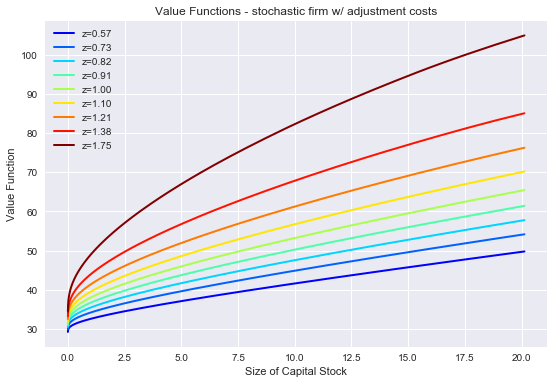

In [222]:
'''
------------------------------------------------------------------------
Find optimal capital and investment policy functions
------------------------------------------------------------------------
optK = (sizek,sizez) vector, optimal choice of k' for each k and z
optI = (sizek,sizez) vector, optimal choice of investment for each k and z
------------------------------------------------------------------------
'''
@jit
def optimal(kvec,PF,delta,sizez,optK=None):
    opt_vec = np.zeros((sizek,sizez))
    for k in range(sizez):
        if optK!=None:
            opt_vec[:,k] = optK[:,k]-(1-delta)*kvec
        else:
            opt_vec[:,k] = kvec[PF[:,k]]
    return opt_vec

optK_full = optimal(kvec,PF,delta,sizez)
optI_full = optimal(kvec,PF,delta,sizez,optK_full)

# Plot Value Function for each choice of capital stock and possible shocks
plt.subplots(figsize=(9, 6))
for k in range(sizez):
    lb = 'z='+format(z_grid[k],'.2f')
    plt.plot(kvec, VF[:,k], color=plt.cm.jet((k+1)/sizez),lw=2,label=lb)
plt.xlabel('Size of Capital Stock')
plt.ylabel('Value Function')
plt.title('Value Functions - stochastic firm w/ adjustment costs')
plt.legend(loc='best')
plt.show()

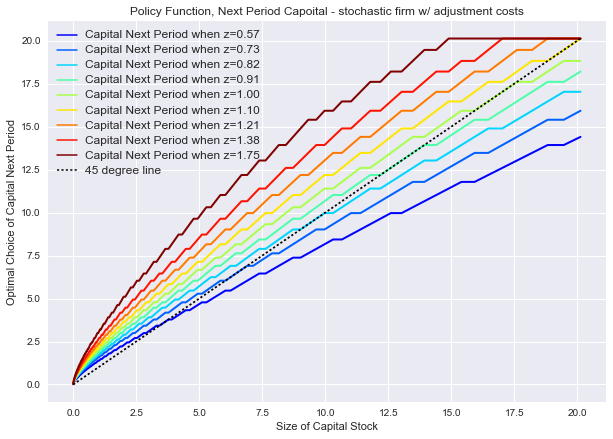

In [223]:
# Plot optimal capital stock rule as a function of firm size
fig, ax = plt.subplots(figsize=(10,7))
for k in range(sizez):
    lb = 'Capital Next Period when z='+format(z_grid[k],'.2f')
    ax.plot(kvec, optK_full[:,k], color=plt.cm.jet((k+1)/sizez),lw=2,label=lb)
ax.plot(kvec, kvec, 'k:', label='45 degree line')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper left', shadow=True)
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital Stock')
plt.ylabel('Optimal Choice of Capital Next Period')
plt.title('Policy Function, Next Period Capoital - stochastic firm w/ ' +
          'adjustment costs')
plt.show()

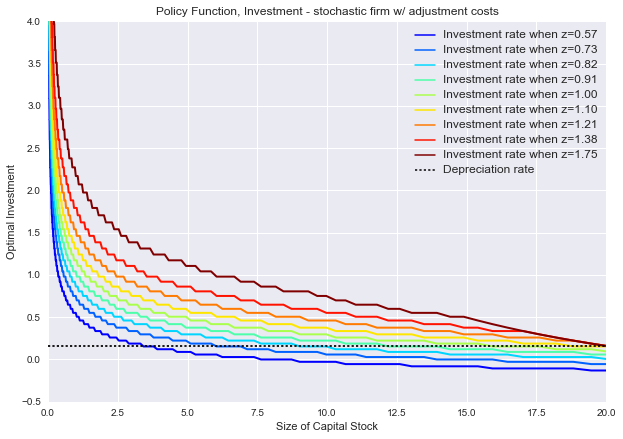

In [224]:
# Plot investment rule as a function of firm size
fig, ax = plt.subplots(figsize=(10,7))
for k in range(sizez):
    lb = 'Investment rate when z='+format(z_grid[k],'.2f')
    ax.plot(kvec, (optI_full[:,k]/kvec), color=plt.cm.jet((k+1)/sizez),lw=2,label=lb)
ax.plot(kvec, (np.ones(sizek)*delta), 'k:', label='Depreciation rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital Stock')
plt.ylabel('Optimal Investment')
plt.axis([0,20,-0.5,4])
plt.title('Policy Function, Investment - stochastic firm w/ adjustment ' +
          'costs')
plt.show()

### Approximate AR(1) Process

In [225]:
num_draws=sizek
# Simulate the Markov process - will make this a function so can call later
def sim_markov(z_grid, pi, num_draws):
    # draw some random numbers on [0, 1]
    u = np.random.uniform(size=num_draws)

    # Do simulations
    z_discrete = np.empty(num_draws)  # this will be a vector of values 
    # we land on in the discretized grid for z
    N = z_grid.shape[0]
    oldind = int(np.ceil((N - 1) / 2)) # set initial value to median of grid
    z_discrete[0] = z_grid[oldind]  
    for i in range(1, num_draws):
        sum_p = 0
        ind = 0
        while sum_p < u[i]:
            sum_p = sum_p + pi[ind, oldind]
            ind += 1
        if ind > 0:
            ind -= 1
        z_discrete[i] = z_grid[ind]
        oldind = ind            
    return z_discrete


# Call simulation function to get simulated values
z_discrete = sim_markov(z_grid, np.transpose(pi), num_draws)

# Find optimal capital and investment given the AR(1) process
@jit
def find_choice(optK_full,optI_full,VF,z_discrete,z_grid,sizek):
    opt_K = np.zeros(sizek)
    opt_I = np.zeros(sizek)
    VF_AR = np.zeros(sizek)
    for i in range(sizek): 
        ind = np.where(z_grid==z_discrete[i])[0]
        opt_K[i] = optK_full[i,ind]
        opt_I[i] = optI_full[i,ind]
        VF_AR[i] = VF[i,ind]
    return opt_K,opt_I, VF_AR

optK, optI, VFAR = find_choice(optK_full,optI_full,VF,z_discrete,z_grid,sizek)

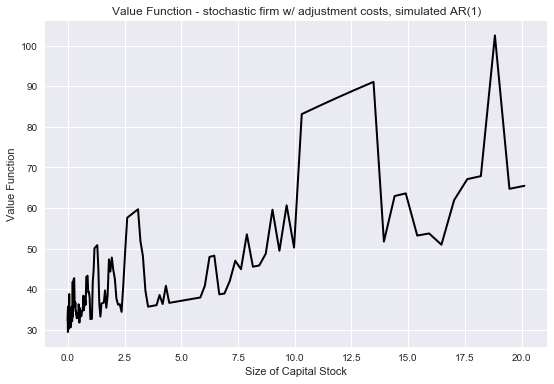

In [226]:
# Plot Value Function for a simulated AR(1)
plt.subplots(figsize=(9, 6))
plt.plot(kvec, VFAR, 'k-',lw=2)
plt.xlabel('Size of Capital Stock')
plt.ylabel('Value Function')
plt.title('Value Function - stochastic firm w/ adjustment costs, simulated AR(1)')
plt.show()

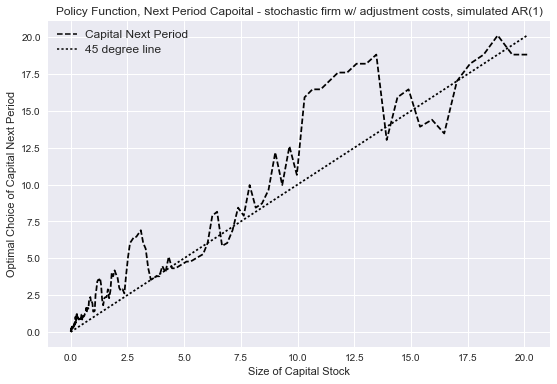

In [227]:
# Plot optimal capital stock rule as a function of firm size
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(kvec, optK, 'k--', label='Capital Next Period')
ax.plot(kvec, kvec, 'k:', label='45 degree line')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper left', shadow=True)
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital Stock')
plt.ylabel('Optimal Choice of Capital Next Period')
plt.title('Policy Function, Next Period Capoital - stochastic firm w/ ' +
          'adjustment costs, simulated AR(1)')
plt.show()

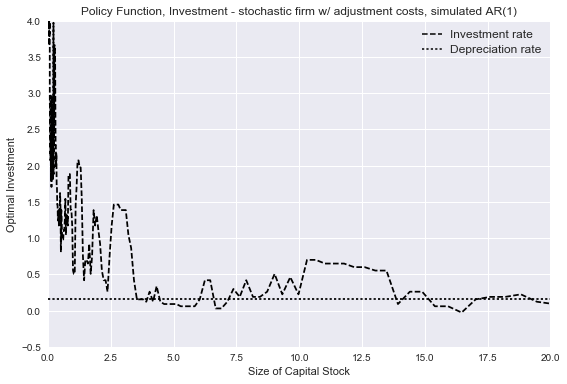

In [228]:
# Plot investment rule as a function of firm size
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(kvec, (optI/kvec), 'k--', label='Investment rate')
ax.plot(kvec, (np.ones(sizek)*delta), 'k:', label='Depreciation rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital Stock')
plt.ylabel('Optimal Investment')
plt.axis([0,20,-0.5,4])
plt.title('Policy Function, Investment - stochastic firm w/ adjustment ' +
          'costs, simulated AR(1)')
plt.show()